# Trasformazioni gemoetriche

# Distorsioni causate da lenti: "barile" e "cuscino"
Marco Zucca



# Introduzione


Quando viene scattata una fotografia il tipo di lente utilizzata per lo scatto deformerà in qualche modo il risultato creando degli effetti in cui l'immagine assume delle curve concave o convesse creando una distorsione detta a "barile" (barrel) e a "cuscino" (pincushion) rispettivamente.

Oltre ad avere effetti negativi, queste distorsioni possono essere utilizzate per diversi scopi, ad esempio le immagini proiettate dai visori di realtà aumentata sono immagini con distorsione a barile

# Obiettivi

- Riuscire a distorcere un'immagine con la distorsione a barile e cuscino
- Provare a correggere immagini deformate applicando la deformazione inversa

# Implementazione

### Librerie

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import data, io, color

#per la creazione di .gif
from PIL import Image, ImageDraw

### Funzioni di supporto
Per rendere il codice più leggibile, vengono utilizzate le seguenti funzioni di supporto per:
- convertire le coordinate cartesiane in coordinate polari per applicare la trasformazione
- ri convertire da coordinate polari a cartesiane per poter rappresentare l'immagine

In [5]:
#converte le coordinate cartesiane in polari
def cart2pol(x,y):
    theta = np.arctan2(y,x)
    rho = np.sqrt(x**2 + y**2)
    return (theta, rho)

In [6]:
#converte le coordinate polari in cartesiane
def pol2cart(theta,rho):
    x = rho*np.cos(theta)
    y = rho*np.sin(theta)
    return (x, y)

### Distorsione da un punto scelto
Prende un'immagine come input e applica la distorisone partendo dal punto definito da wpx e wpy con fattore di deformazione rf. Se viene inserito un valore negativo si crea una distorsione a barile, se positivo a cuscino


In [7]:
def lensDistorsion(image,wpx,wpy,scale,rf):
    width,height=image.shape[:2]
    print(width,height)
    if  (wpx > width or wpx < 0) or (wpy > height or wpy < 0):
        print("Punto non valido")
        return
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    R = np.sqrt((width/2)**2 + (height/2)**2)

    for u in range(width):
        for v in range(height):
            
            x1 = u-wpx
            y1 = v-wpy
            
            x2 /= scale
            y2 /= scale
            
            #converte da cordinate cartesaine a polari
            theta,r = cart2pol(x2,y2)
            #normalizzazione
            r = r/R
            #modello
            s = r*(1 + rf*(r**2))
            #de-normalizza
            s2 = s*R
            #riconverte da cordiante poalri a cartesiane
            x4,y4 = pol2cart(theta,s2)
            #trasla al punto originario
            x = x3+wpx
            y = y3+wpy

            
            intx, inty = int(x), int(y)
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

### Distorsione dal centro
Come la precedente ma il punto da cui parte la distorsione è il centro

In [4]:
def lensDistorsionCenter(image,scale,rf):
    width,height=image.shape[:2]
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    R = np.sqrt((width/2)**2 + (height/2)**2)
    w2 = width/2
    h2 = height/2
    
    for u in range(width):
        for v in range(height):
            #trasla al centro
            x2 = u-w2
            y2 = v-h2
            #scala se necessario
            x2 /= scale
            y2 /= scale
            #converte da cordinate cartesaine a polari
            theta,r = cart2pol(x2,y2)
            #normalizzazione
            r = r/R
            #modello
            s = r*(1 + rf*(r**2))
            #de-normalizza
            s2 = s*R
            #riconverte da cordiante poalri a cartesiane
            x4,y4 = pol2cart(theta,s2)
            #traasla al punto originario
            x = x4+w2
            y = y4+h2
            
            intx, inty = int(x), int(y)
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

Si applica una traslazione all'inizio della funzione e alla fine prima di ritornarre il pixel corrispondente distorto. 

Dopo di che si puo' decidere se scalare l'immagine secondo un fattore preso come parametro, questa operazione puo' essere necesasria perchè applicando certe trasformazioni è possibile ottenere dei margini o effetti non voluti(come si vedrà in seguito).

Si converte da coordinate cartesiane a polari perchè è più naturale pensare in questi termini per implemetare la trasformazione: la traformazione è "concentrica" dal punto in cui inizia, ovvero, dal punto di partenza (come puo' essere il centro dell'immagine) si cambia mano a mano la distanza da esso a seconda del parametro, quindi si cambia il valore di rho (modulo) ed a ogni iterazione si cambia il valore di theta (fase), rho rappresenta anche la distanza tra il punto dell'immagine distorta e il punto di distorisione, necessaria per applicare il modello.

Prima di applicare il modello vero e proprio si normalizza moltilpicando il modulo ottenuto con la la distanza dal centro dell'immagine.

Il modello applicato è una semplificazione della formula della "radial distorsion" in cui viene utilizzato solo un parametro (rf) per calcolare la distorsione. In teoria la formula accetta un numero indefinito di parametri per raggiungere una precisone sempre maggiore e ricostruire l'immagine in modo più fedele, ma per i nostri scopi (ed in generale nella maggior parte dei casi) un solo parametro è sufficiente.

Prima di applicare il mapping inverso per costruire l'immagine distorta, bisogna de-normalizzare l'immagine e ri-traslare il punto dal centro a dove si trovava in origine.

# Analisi sperimentali

### Immagini test

In questa prima parte verranno utilizzate immagini con griglie e linee per poter notare al meglio le trasformazioni applicate e il loro risultato.
Prima di tutto si prova a distorcere un'immagine "normale" per osservare il risultato dopo la distorsione, si applica lo stesso fattore di distorsione ma con segno opposto:

In [6]:
img = io.imread('img/test_grid.jpg')

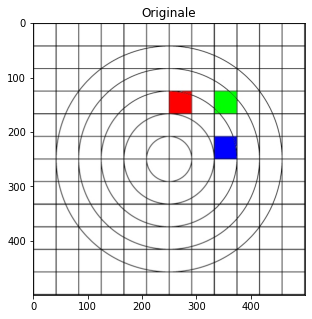

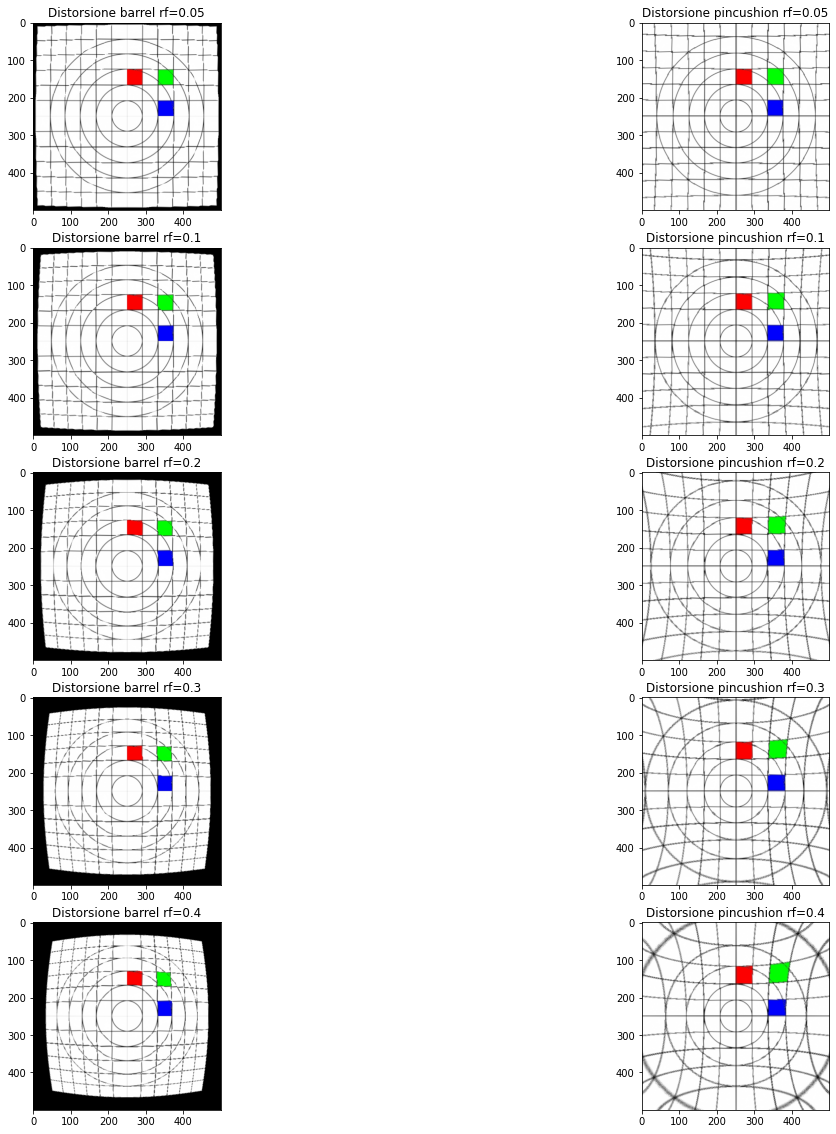

In [7]:
gifBarrel = []
gifBarrel.append(Image.fromarray(img))
gifPin = []
gifPin.append(Image.fromarray(img))

imgBarrel05 = lensDistorsionCenter(img,1,+0.05)
gifBarrel.append(Image.fromarray(imgBarrel05))
imgPin05 = lensDistorsionCenter(img,1,-0.05)
gifPin.append(Image.fromarray(imgPin05))

imgBarrel1 = lensDistorsionCenter(img,1,+0.1)
gifBarrel.append(Image.fromarray(imgBarrel1))
imgPin1 = lensDistorsionCenter(img,1,-0.1)
gifPin.append(Image.fromarray(imgPin1))

imgBarrel2 = lensDistorsionCenter(img,1,+0.2)
gifBarrel.append(Image.fromarray(imgBarrel2))
imgPin2 = lensDistorsionCenter(img,1,-0.2)
gifPin.append(Image.fromarray(imgPin2))

imgBarrel3 = lensDistorsionCenter(img,1,+0.3)
gifBarrel.append(Image.fromarray(imgBarrel3))
imgPin3 = lensDistorsionCenter(img,1,-0.3)
gifPin.append(Image.fromarray(imgPin3))

imgBarrel4 = lensDistorsionCenter(img,1,+0.4)
gifBarrel.append(Image.fromarray(imgBarrel4))
imgPin4 = lensDistorsionCenter(img,1,-0.4)
gifPin.append(Image.fromarray(imgPin4))



plt.figure(figsize=(5,5))
plt.subplot(1,1,1)
plt.title("Originale")
plt.imshow(img)

plt.figure(figsize=(20,20))

plt.subplot(5,2,1)
plt.title("Distorsione barrel rf=0.05")
plt.imshow(imgBarrel05)

plt.subplot(5,2,2)
plt.title("Distorsione pincushion rf=0.05")
plt.imshow(imgPin05)

plt.subplot(5,2,3)
plt.title("Distorsione barrel rf=0.1")
plt.imshow(imgBarrel1)

plt.subplot(5,2,4)
plt.title("Distorsione pincushion rf=0.1")
plt.imshow(imgPin1)

plt.subplot(5,2,5)
plt.title("Distorsione barrel rf=0.2")
plt.imshow(imgBarrel2)

plt.subplot(5,2,6)
plt.title("Distorsione pincushion rf=0.2")
plt.imshow(imgPin2)

plt.subplot(5,2,7)
plt.title("Distorsione barrel rf=0.3")
plt.imshow(imgBarrel3)

plt.subplot(5,2,8)
plt.title("Distorsione pincushion rf=0.3")
plt.imshow(imgPin3)

plt.subplot(5,2,9)
plt.title("Distorsione barrel rf=0.4")
plt.imshow(imgBarrel4)

plt.subplot(5,2,10)
plt.title("Distorsione pincushion rf=0.4")
plt.imshow(imgPin4)


gifBarrel[0].save(fp='img/output/gridBarrel.gif',
            format='GIF', append_images=gifBarrel,
            save_all=True, duration=400, loop=0)

gifBarrel[0].save(fp='img/output/gridPin.gif',
            format='GIF', append_images=gifPin,
            save_all=True, duration=400, loop=0)

Successione delle immagini distorte create:

|Barrel   |Pincushion   |
|---:|---:|
|![gridBarrel](img/output/gridBarrel.gif "grid barrel")| ![gridPin](img/output/gridPin.gif "grid pin")|




Dalle immagini si puo' vedere che le trasformazioni vengono applicate correttamente.
Questa immagine evidenzia bene il fatto che le linee dopo la trasformazione non risultano perfettamente "continue", creando linee e curve a scalini. Questi effetti potrebbero derivare dall'implementazione del mapping inverso 

Si prova a correggere la distorsione appena creata applicando la distorsione inversa:

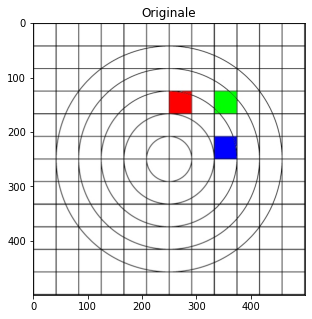

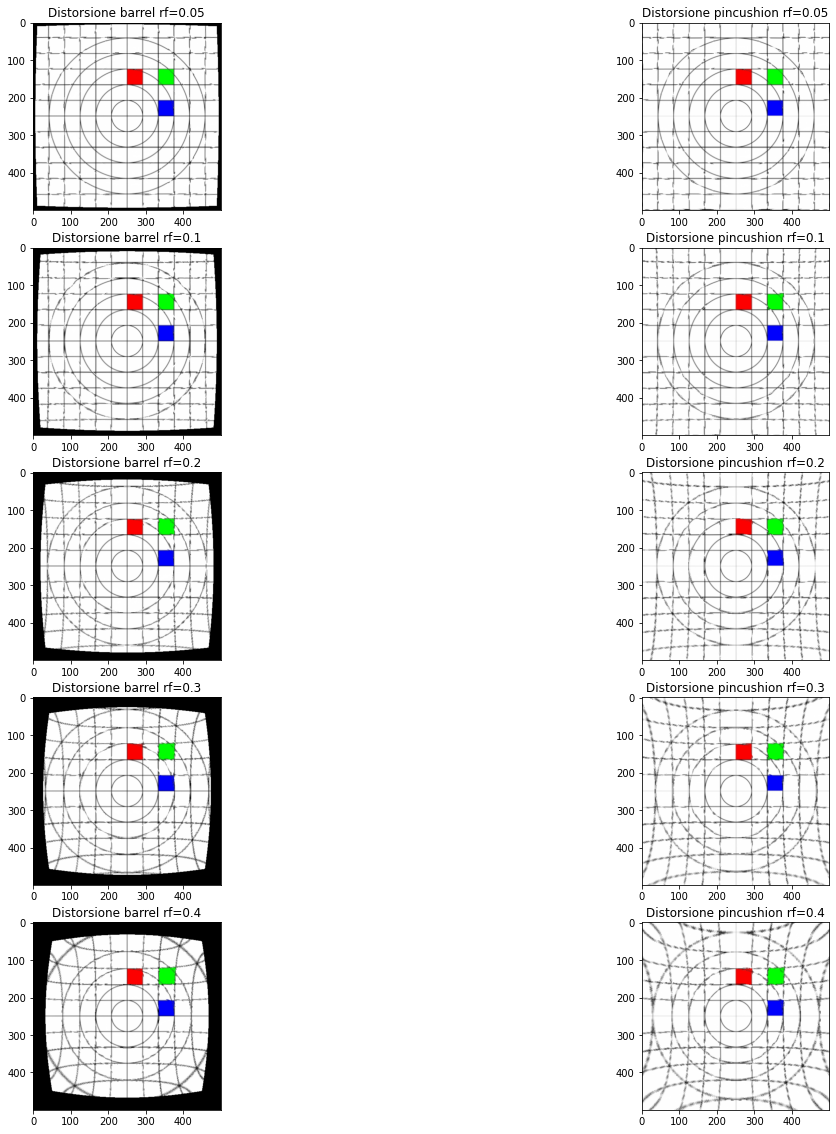

In [8]:
imgBarrel05f = lensDistorsionCenter(imgPin05,1,+0.05)
imgPin05f = lensDistorsionCenter(imgBarrel05,1,-0.05)

imgBarrel1f = lensDistorsionCenter(imgPin1,1,+0.1)
imgPin1f = lensDistorsionCenter(imgBarrel1,1,-0.1)

imgBarrel2f = lensDistorsionCenter(imgPin2,1,+0.2)
imgPin2f = lensDistorsionCenter(imgBarrel2,1,-0.2)

imgBarrel3f = lensDistorsionCenter(imgPin3,1,+0.3)
imgPin3f = lensDistorsionCenter(imgBarrel3,1,-0.3)

imgBarrel4f = lensDistorsionCenter(imgPin4,1,+0.4)
imgPin4f = lensDistorsionCenter(imgBarrel4,1,-0.4)

plt.figure(figsize=(5,5))
plt.subplot(1,1,1)
plt.title("Originale")
plt.imshow(img)

plt.figure(figsize=(20,20))

plt.subplot(5,2,1)
plt.title("Distorsione barrel rf=0.05")
plt.imshow(imgBarrel05f)

plt.subplot(5,2,2)
plt.title("Distorsione pincushion rf=0.05")
plt.imshow(imgPin05f)

plt.subplot(5,2,3)
plt.title("Distorsione barrel rf=0.1")
plt.imshow(imgBarrel1f)

plt.subplot(5,2,4)
plt.title("Distorsione pincushion rf=0.1")
plt.imshow(imgPin1f)

plt.subplot(5,2,5)
plt.title("Distorsione barrel rf=0.2")
plt.imshow(imgBarrel2f)

plt.subplot(5,2,6)
plt.title("Distorsione pincushion rf=0.2")
plt.imshow(imgPin2f)

plt.subplot(5,2,7)
plt.title("Distorsione barrel rf=0.3")
plt.imshow(imgBarrel3f)

plt.subplot(5,2,8)
plt.title("Distorsione pincushion rf=0.3")
plt.imshow(imgPin3f)

plt.subplot(5,2,9)
plt.title("Distorsione barrel rf=0.4")
plt.imshow(imgBarrel4f)

plt.subplot(5,2,10)
plt.title("Distorsione pincushion rf=0.4")
plt.imshow(imgPin4f)

Applicando la trasformazione inversa, utilizzando lo stesso fattore di distorsione, non si riesce a ritornare all'immagine iniziale. Per ritornare allo stato iniziale quindi bisogna cambiare i fattori di trasformazione

### Volti

Si prova ora a correggere immagini reali già distorte in partenza (è stato utilizzato GIMP per applicare la deformazione) applicando la distorsione opposta.

Si utilizzerà un volto così da notare le proporzioni sbagliate dovute alla trasformazione.

Per ottenere una distorsione a cuscino "evidente", si è dovuta diminuire la dimensione dell'immagine, questo porta ad un'abbassamento della qualità quando si cercherà di correggerla.

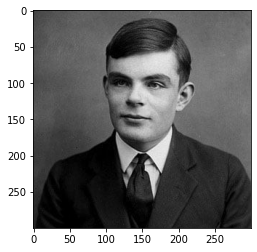

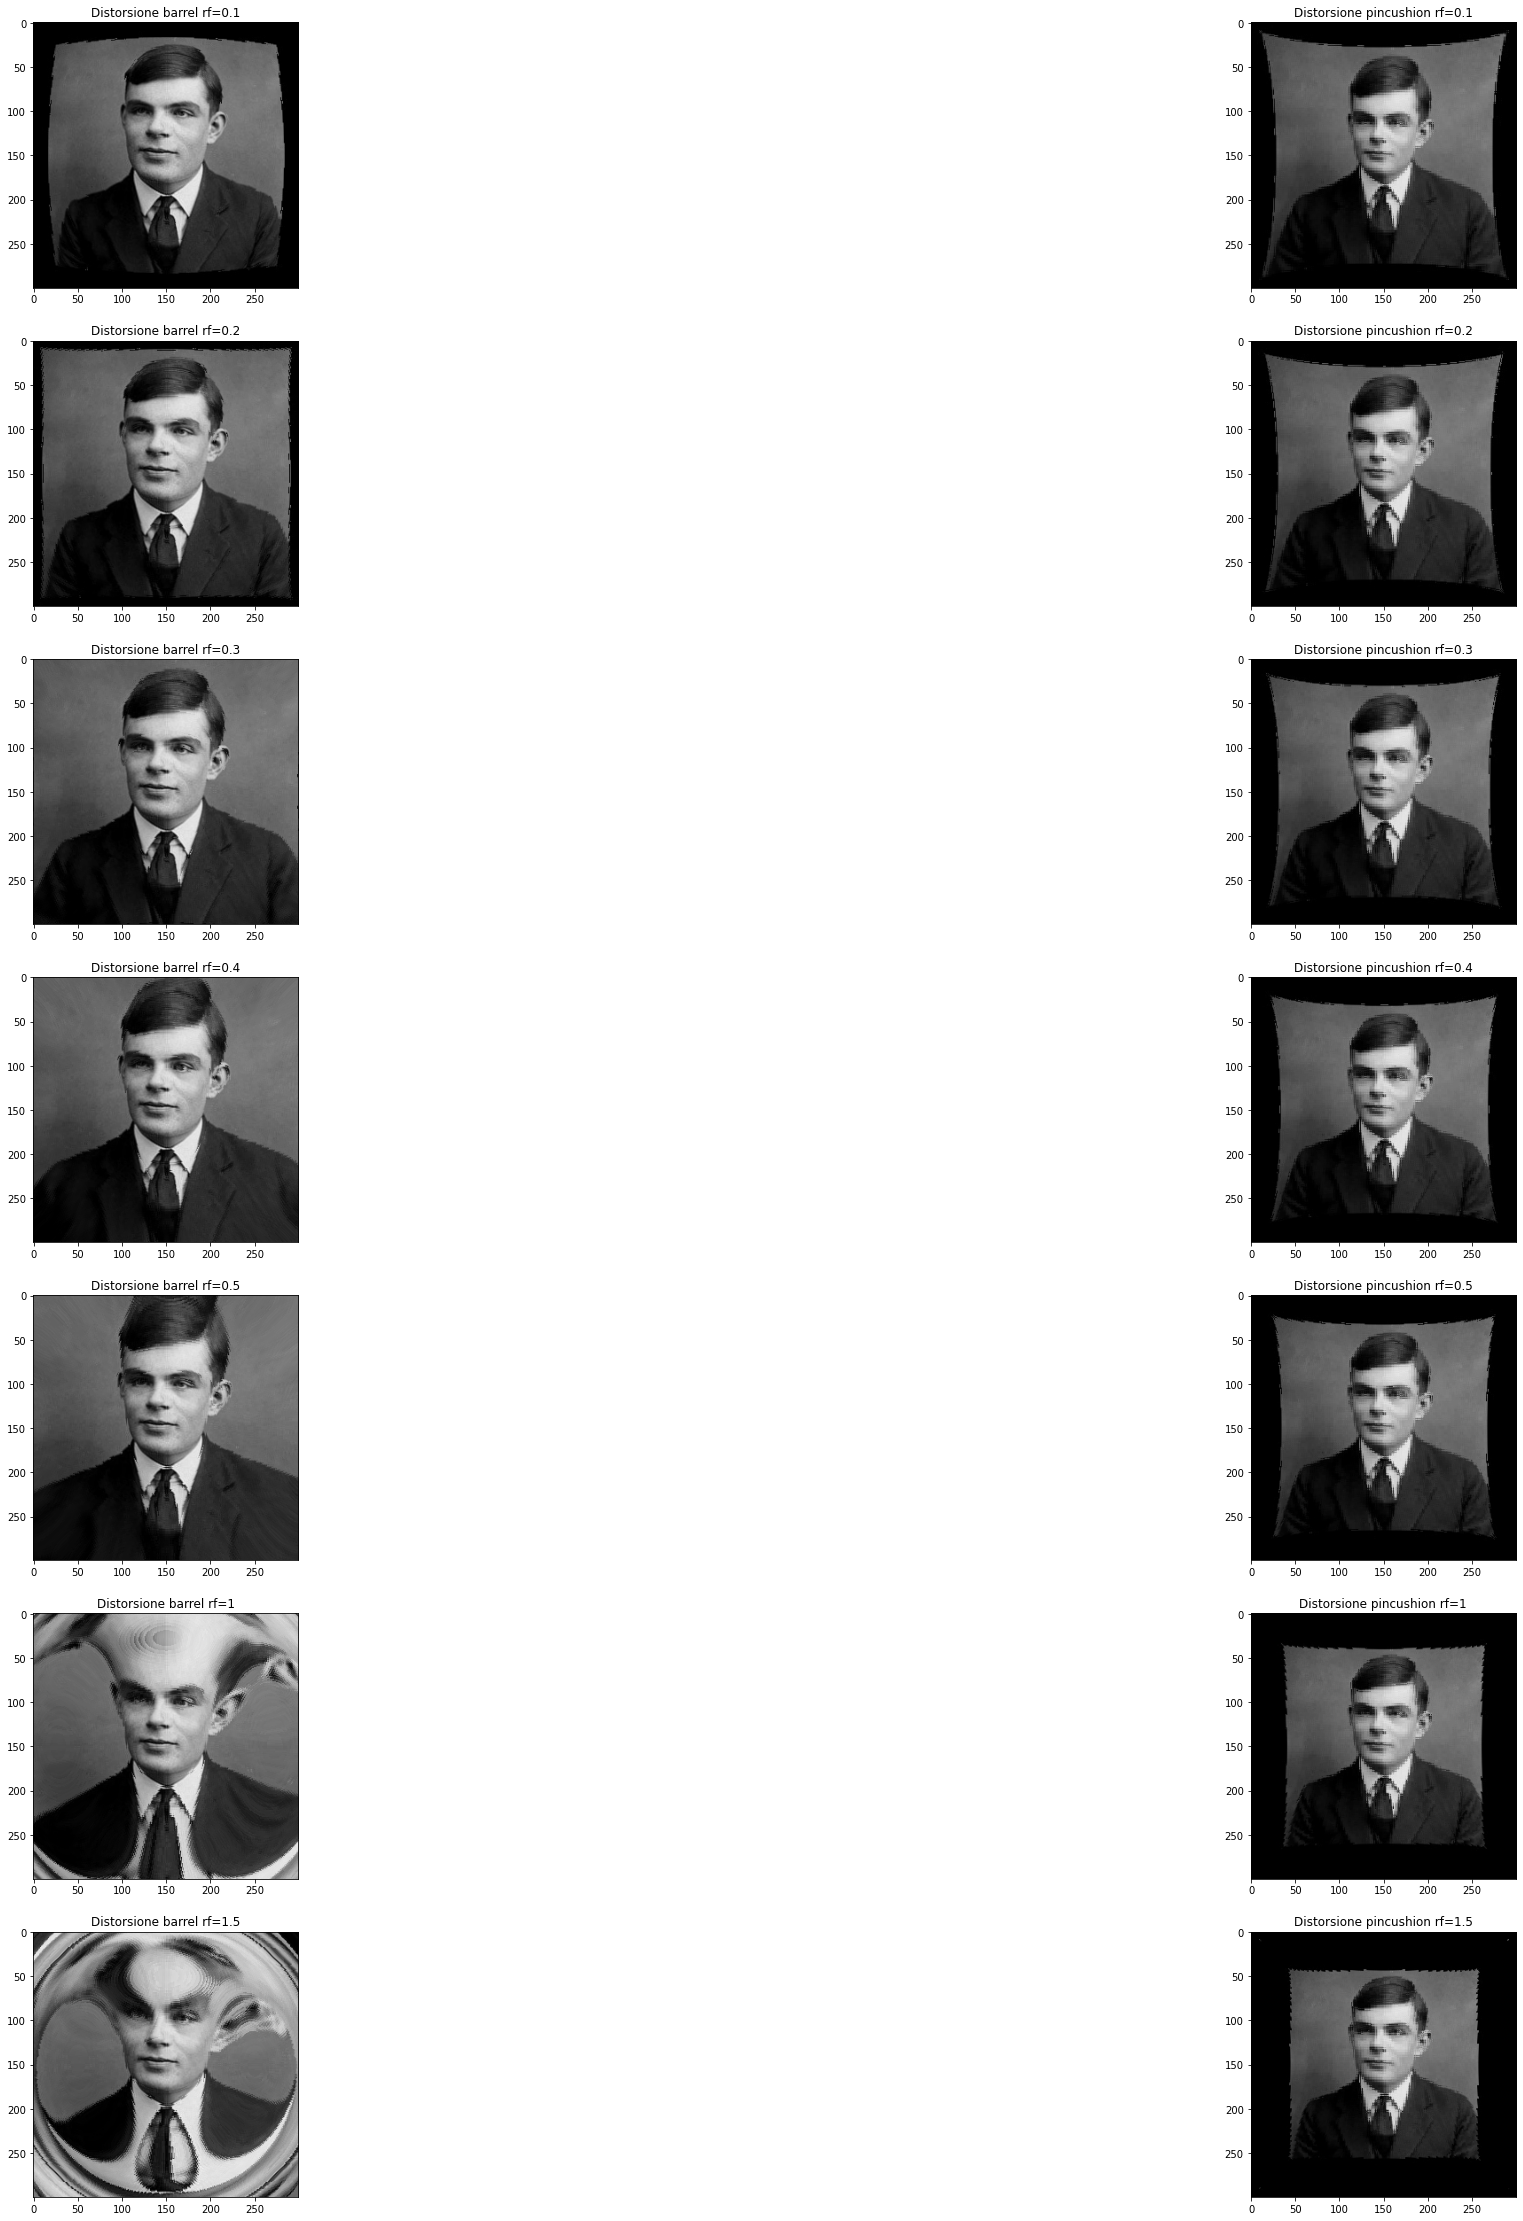

In [9]:
original = io.imread('img/turing.jpg')
pin = io.imread('img/turing_pincushion.jpg')
barrel = io.imread('img/turing_barrel.jpg')

gifBarrel = []
gifBarrel.append(Image.fromarray(barrel))
gifPin = []
gifPin.append(Image.fromarray(pin))

pin1 = lensDistorsionCenter(pin,1.5,+0.1)
gifPin.append(Image.fromarray(pin1))
barrel1 = lensDistorsionCenter(barrel,1,-0.1)
gifBarrel.append(Image.fromarray(barrel1))

pin2 = lensDistorsionCenter(pin,1.5,+0.2)
gifPin.append(Image.fromarray(pin2))
barrel2 = lensDistorsionCenter(barrel,1,-0.2)
gifBarrel.append(Image.fromarray(barrel2))


pin3 = lensDistorsionCenter(pin,1.5,+0.3)
gifPin.append(Image.fromarray(pin3))
barrel3 = lensDistorsionCenter(barrel,1,-0.3)
gifBarrel.append(Image.fromarray(barrel3))


pin4 = lensDistorsionCenter(pin,1.5,+0.4)
gifPin.append(Image.fromarray(pin4))
barrel4 = lensDistorsionCenter(barrel,1,-0.4)
gifBarrel.append(Image.fromarray(barrel4))

pin5 = lensDistorsionCenter(pin,1.5,+0.5)
gifPin.append(Image.fromarray(pin5))
barrel5 = lensDistorsionCenter(barrel,1,-0.5)
gifBarrel.append(Image.fromarray(barrel5))

pin6 = lensDistorsionCenter(pin,1.5,+1)
gifPin.append(Image.fromarray(pin6))
barrel6 = lensDistorsionCenter(barrel,1,-1)
gifBarrel.append(Image.fromarray(barrel6))

pin7 = lensDistorsionCenter(pin,1.5,+1.5)
gifPin.append(Image.fromarray(pin7))
barrel7 = lensDistorsionCenter(barrel,1,-1.5)
gifBarrel.append(Image.fromarray(barrel7))


#-----------------------------------------------#

#plt.figure(figsize=(10,10))
plt.imshow(original)

plt.figure(figsize=(40,40))
plt.subplot(7,2,1)
plt.title("Distorsione barrel rf=0.1")
plt.imshow(barrel1)

plt.subplot(7,2,2)
plt.title("Distorsione pincushion rf=0.1")
plt.imshow(pin1)

plt.subplot(7,2,3)
plt.title("Distorsione barrel rf=0.2")
plt.imshow(barrel2)

plt.subplot(7,2,4)
plt.title("Distorsione pincushion rf=0.2")
plt.imshow(pin2)

plt.subplot(7,2,5)
plt.title("Distorsione barrel rf=0.3")
plt.imshow(barrel3)

plt.subplot(7,2,6)
plt.title("Distorsione pincushion rf=0.3")
plt.imshow(pin3)

plt.subplot(7,2,7)
plt.title("Distorsione barrel rf=0.4")
plt.imshow(barrel4)

plt.subplot(7,2,8)
plt.title("Distorsione pincushion rf=0.4")
plt.imshow(pin4)

plt.subplot(7,2,9)
plt.title("Distorsione barrel rf=0.5")
plt.imshow(barrel5)

plt.subplot(7,2,10)
plt.title("Distorsione pincushion rf=0.5")
plt.imshow(pin5)

plt.subplot(7,2,11)
plt.title("Distorsione barrel rf=1")
plt.imshow(barrel6)

plt.subplot(7,2,12)
plt.title("Distorsione pincushion rf=1")
plt.imshow(pin6)

plt.subplot(7,2,13)
plt.title("Distorsione barrel rf=1.5")
plt.imshow(barrel7)

plt.subplot(7,2,14)
plt.title("Distorsione pincushion rf=1.5")
plt.imshow(pin7)

gifBarrel[0].save(fp='img/output/turingBarrel.gif',
            format='GIF', append_images=gifBarrel,
            save_all=True, duration=400, loop=0)

gifPin[0].save(fp='img/output/turingPin.gif',
            format='GIF', append_images=gifPin,
            save_all=True, duration=400, loop=0)

Successione delle immagini distorte create:

| | |
|:|:|
|![turingBarrel](img/output/turingBarrel.gif "turing barrel") |![turingPin](img/output/turingPin.gif "turing pin")|

Si nota, per l'immagine con distorsione barrel, come con un fattore di distorsione pari a -0.3 si ottiene un'immagine simile a quella originale  , mentre per l'immagine con distorsione pincushion, serve un fattore di circa 1.5. 

Questa differenza puo' essere data dal fatto che l'immagine distorta a pincushion abbia una risoluzione più bassa.

# Immagini "reali"

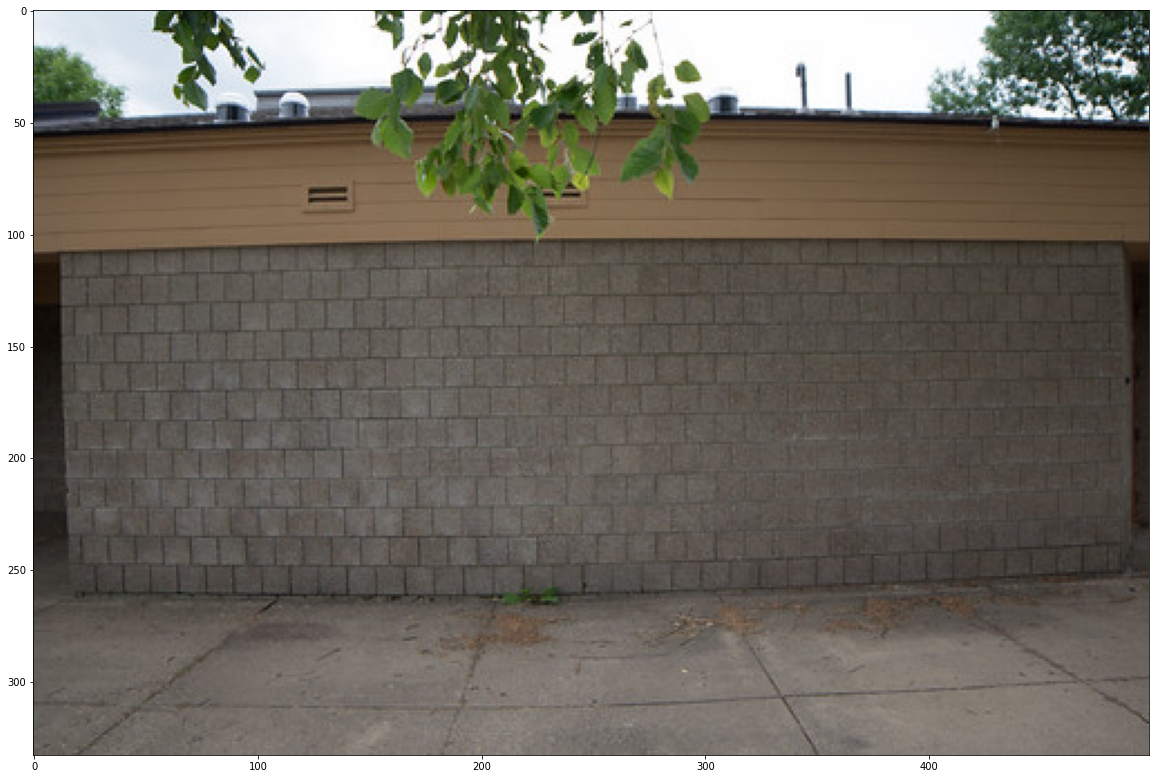

In [46]:
wall = io.imread('img/barrel_wall.jpg')
plt.figure(figsize=(20,20))
plt.imshow(wall)


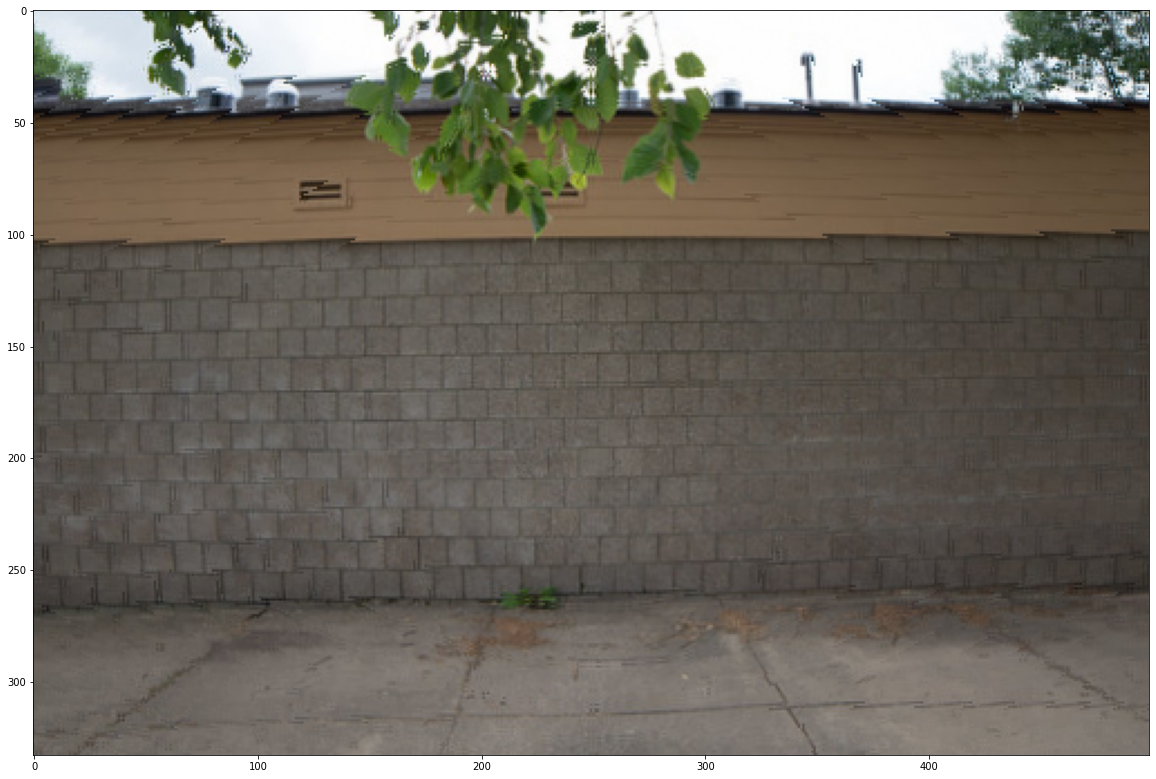

In [56]:
wallc = lensDistorsionCenter(wall,1,-0.09)
plt.figure(figsize=(20,20))
plt.imshow(wallc)

L'immagine risulta essere leggermente inclinta da un lato, proviamo a ruotarla:

In [64]:
def rotationCenter(image, angle):
    width,height=image.shape[:2]   
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    for u in range(width):
        for v in range(height):
            #traslate
            x1 = u-width/2
            y1 = v-height/2
            #rotate
            x2 = x1*np.cos(-angle)+ y1*np.sin(-angle)
            y2 = -x1*np.sin(-angle)+y1*np.cos(-angle)
            #traslate
            x = x2+width/2
            y = y2+height/2
            
            intx, inty = int(x), int(y)
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst



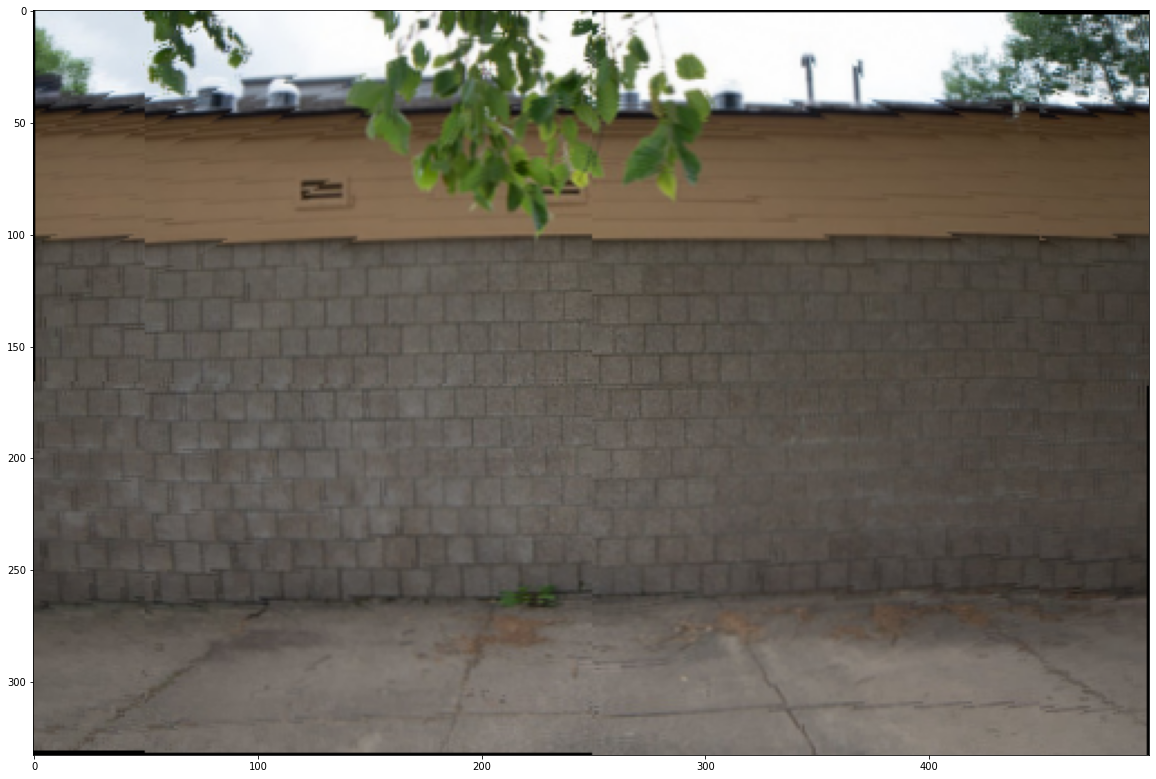

In [77]:
wallcr = rotationCenter(wallc,0.005)
plt.figure(figsize=(20,20))
plt.imshow(wallcr)

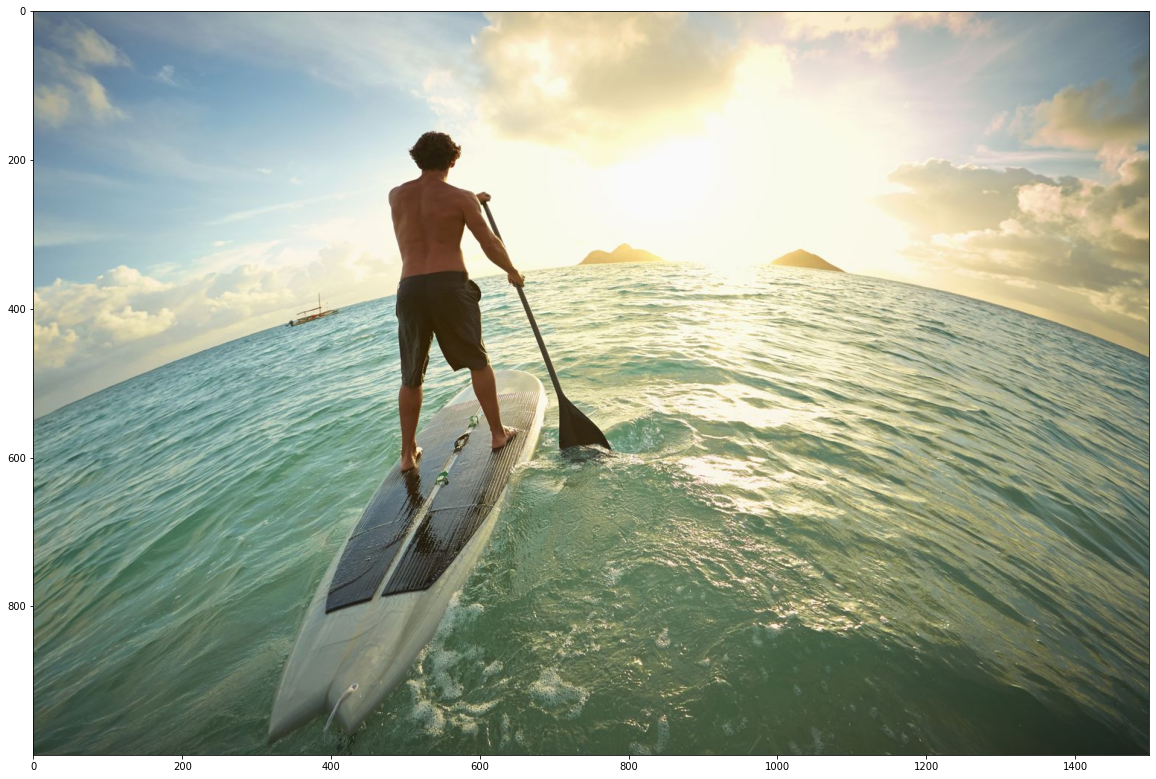

In [69]:
surf = io.imread('img/surfer.jpg')
plt.figure(figsize=(20,20))
plt.imshow(surf)

In [76]:
factor = [-0.1,-0.2,-0.3,-0.3,-0.4]
gif = []
for i in factor:
    gif.append(Image.fromarray(lensDistorsionCenter(surf,1,i)))


gif[0].save(fp='img/output/surferCorrection.gif',
            format='GIF', append_images=gif,
            save_all=True, duration=400, loop=0)


![surf](img/output/surferCorrection.gif "surf") 

Si vede che per immagini con una distorsione piccola (la prima), la correzione risulta più o meno corretta, o almeno si nota un miglioramento. Per immagini con una distorsione più marcata, la correzione presenta artefatti e un risultato in generale non troppo soddisfacente.

Nel caso dell'ultima immagine, per ottenere una risultato migliore si potrebbe decidere di scalre l'immagine per ottenerne una più piccola, ovviamente perdendo informazione

# Conclusione

In conclusione, si è riusciti ad implementare una funzione in grado di eseguire le due trasformazioni, sia per distorcere un'immagine corretta in partenza che per correggere immagini deformate. Si è notata una perdita di qualità e l'aggiunta di artefatti o elementi non voluti dopo la trasformazione, inoltre la distorsione, così com'è stata implementata risulta piuttosto lenta e pesante

# Fonti
- https://www.mathworks.com/matlabcentral/fileexchange/37980-barrel-and-pincushion-lens-distortion-correction per l'implementazione

- https://en.wikipedia.org/wiki/Distortion_(optics)

- https://stackoverflow.com/questions/6199636/formulas-for-barrel-pincushion-distortion (il link al paper originale non è più disponibile, ma nel post viene usato un frammento di esso)

- http://www.paulbourke.net/miscellaneous/imagewarp/
    
